In [1]:
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['from', 'subject', 're', 'edu', 'use'])
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\Ikshita\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


#### Remove Emails and New Line Characters

In [3]:
data = df.content.values.tolist()
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]
pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


#### Tokenize words and Clean-up text

In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))


#### Remove Stopwords, Make Bigrams and Lemmatize

In [5]:
# Remove Stop Words
data_words_nostops = [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in data_words] 
# Form Bigrams
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_words_bigrams = [bigram_mod[doc] for doc in data_words_nostops]
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
texts_out = []
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
for sent in data_words_bigrams:
    doc = nlp(" ".join(sent)) 
    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])


#### Create the Dictionary and Corpus needed for Topic Modeling

In [6]:
# Create Dictionary
id2word = corpora.Dictionary(texts_out)
# Create Corpus
texts = texts_out
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


#### Building the Topic Model

In [7]:
print(id2word)

Dictionary(72316 unique tokens: ['addition', 'anyone', 'body', 'bricklin', 'bring']...)


In [8]:
#alpha and eta are hyperparameters that affect sparsity of the topics. 
#chunksize is the number of documents to be used in each training chunk
#update_every determines how often the model parameters should be updated
#passes is the total number of training passes.
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=20, random_state=100,update_every=1,
                                            chunksize=100,passes=10,alpha='auto',per_word_topics=True)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"_" + 0.029*"blue" + 0.021*"tank" + 0.014*"cubs_suck" + 0.012*"eg" + '
  '0.012*"gas" + 0.011*"hi" + 0.007*"henry_spencer" + 0.007*"cigarette" + '
  '0.006*"xlib"'),
 (1,
  '0.020*"value" + 0.020*"bus" + 0.019*"specifically" + 0.015*"function" + '
  '0.015*"associate" + 0.013*"motorcycle" + 0.011*"properly" + 0.010*"code" + '
  '0.008*"confuse" + 0.008*"error"'),
 (2,
  '0.023*"window" + 0.020*"card" + 0.017*"file" + 0.014*"drive" + 0.013*"use" '
  '+ 0.013*"system" + 0.011*"problem" + 0.010*"run" + 0.009*"color" + '
  '0.009*"do"'),
 (3,
  '0.035*"game" + 0.033*"team" + 0.019*"player" + 0.017*"play" + 0.017*"win" + '
  '0.016*"hockey" + 0.013*"season" + 0.011*"contact" + 0.011*"year" + '
  '0.010*"nhl"'),
 (4,
  '0.026*"wire" + 0.017*"circuit" + 0.015*"faq" + 0.015*"connect" + '
  '0.013*"wiring" + 0.013*"voice" + 0.013*"cover" + 0.011*"outlet" + '
  '0.011*"neutral" + 0.010*"conference"'),
 (5,
  '0.030*"government" + 0.024*"gun" + 0.022*"law" + 0.017*"state" + '
  '0.0

#### Evaluation of Model

In [9]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_out, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.75409482553

Coherence Score:  0.515758393755


In [10]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Ikshita\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.336892 -0.001186       1        1  16.246733
13     0.291058 -0.003225       2        1  15.224995
18     0.328823 -0.128118       3        1  14.577824
2      0.091710  0.226508       4        1   6.162339
15     0.059628  0.222493       5        1   5.974163
10    -0.085009 -0.113079       6        1   4.344127
17     0.060776 -0.183154       7        1   4.177486
12    -0.021520 -0.036637       8        1   3.603390
5     -0.022913 -0.021300       9        1   3.365231
16    -0.029277  0.219698      10        1   3.271729
6     -0.063001 -0.016654      11        1   3.222923
9     -0.062892  0.139421      12        1   2.968440
14    -0.088886 -0.062650      13        1   2.740013
3     -0.047744 -0.117434      14        1   2.731154
8     -0.111454  0.003687      15        1   2.292007
19    -0.113680 -0.023410      16        1   2.124459
11    -0.092441 -0.110485      17        1   2.077296
4     -0.134206  0.001616      18        1   1.694687
0     -0.164223 -0.028030      19        1   1.679201
1     -0.131641  0.031942      20        1   1.521808, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
4146   Default  57084.000000            ax  57084.000000  30.0000  30.0000
21     Default  12491.000000          line  12491.000000  29.0000  29.0000
82     Default  16291.000000           not  16291.000000  28.0000  28.0000
30     Default  11142.000000  organization  11142.000000  27.0000  27.0000
3721   Default   3844.000000           max   3844.000000  26.0000  26.0000
65     Default  10452.000000            do  10452.000000  25.0000  25.0000
322    Default   9655.000000         write   9655.000000  24.0000  24.0000
55     Default   7586.000000       article   7586.000000  23.0000  23.0000
244    Default   8046.000000            be   8046.000000  22.0000  22.0000
154    Default  11782.000000         would  11782.000000  21.0000  21.0000
303    Default   6905.000000           say   6905.000000  20.0000  20.0000
226    Default   5803.000000            go   5803.000000  19.0000  19.0000
29     Default   4407.000000     nntp_post   4407.000000  18.0000  18.0000
16     Default   4083.000000          host   4083.000000  17.0000  17.0000
118    Default   6852.000000           get   6852.000000  16.0000  16.0000
46     Default   5027.000000    university   5027.000000  15.0000  15.0000
1911   Default   1863.000000         space   1863.000000  14.0000  14.0000
215    Default   2294.000000        window   2294.000000  13.0000  13.0000
36     Default   3735.000000             s   3735.000000  12.0000  12.0000
18     Default   7291.000000          know   7291.000000  11.0000  11.0000
50     Default   3461.000000          year   3461.000000  10.0000  10.0000
317    Default   4598.000000           use   4598.000000   9.0000   9.0000
2726   Default   1540.000000          game   1540.000000   8.0000   8.0000
23     Default   1949.000000          mail   1949.000000   7.0000   7.0000
681    Default   3006.000000         right   3006.000000   6.0000   6.0000
967    Default   1685.000000     christian   1685.000000   5.0000   5.0000
1362   Default   1746.000000    government   1746.000000   4.0000   4.0000
567    Default   1464.000000          team   1464.000000   3.0000   3.0000
206    Default   3380.000000        system   3380.000000   2.0000   2.0000
60     Default   2012.000000          card   2012.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
11736  Topic20    119.370758          guru    120.322670   4.1773  -5.3260
3548   Topic20    117.623245  countersteer    118.575157   4.1772  -5.3407
10436  Topic20    113.025902       bradley    113.977814   4.1769  -5.3806
280    Topic20    112.216576          lane    113.168488   4.1768  -5

In [11]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = 'C:\\Users\\Ikshita\\Downloads\\mallet-2.0.8'

mallet_path = 'C:\\Users\\Ikshita\\Downloads\\mallet-2.0.8\\bin\\mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts_out, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

[(16,
  [('mail', 0.027440672874737157),
   ('post', 0.022048663262240913),
   ('send', 0.017332532291979574),
   ('information', 0.01557524782216882),
   ('list', 0.014719134875337939),
   ('internet', 0.013832982877741063),
   ('email', 0.013262240913187144),
   ('address', 0.012676479423250226),
   ('group', 0.011489936917993391),
   ('computer', 0.0090717933313307301)]),
 (0,
  [('file', 0.021895566836588699),
   ('window', 0.017995485231620336),
   ('program', 0.012887226172938944),
   ('image', 0.010820606844219295),
   ('version', 0.01017412592600443),
   ('display', 0.0089553504244518165),
   ('server', 0.0083830558411140677),
   ('run', 0.0082770753627181871),
   ('graphic', 0.0074716237269095032),
   ('application', 0.0073762412963532115)]),
 (10,
  [('ax', 0.84984750589017533),
   ('max', 0.062211815041267361),
   ('tm', 0.0023705245508289607),
   ('qax', 0.0020236185190003323),
   ('_', 0.0012141711114001994),
   ('mf', 0.0011418990214359019),
   ('giz', 0.00101180925950016

In [12]:
coherence_ldamallet

0.6151165187625548

#### How to find the optimal number of topics for LDA?

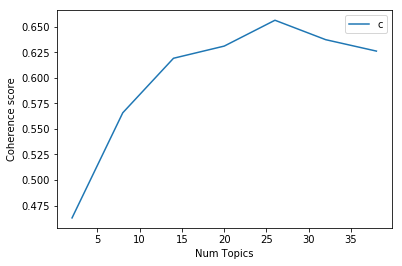

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts_out, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [14]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 2  has Coherence Value of 0.463
Num Topics = 8  has Coherence Value of 0.566
Num Topics = 14  has Coherence Value of 0.619
Num Topics = 20  has Coherence Value of 0.631
Num Topics = 26  has Coherence Value of 0.656
Num Topics = 32  has Coherence Value of 0.637
Num Topics = 38  has Coherence Value of 0.626


In [15]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.029*"file" + 0.012*"program" + 0.012*"version" + 0.011*"image" + '
  '0.010*"software" + 0.009*"include" + 0.008*"system" + 0.008*"source" + '
  '0.008*"information" + 0.008*"run"'),
 (1,
  '0.853*"ax" + 0.062*"max" + 0.002*"tm" + 0.002*"qax" + 0.001*"_" + '
  '0.001*"giz" + 0.001*"mf" + 0.001*"ml" + 0.001*"gq" + 0.001*"wm_wm"'),
 (2,
  '0.025*"mail" + 0.024*"line" + 0.022*"organization" + 0.016*"sale" + '
  '0.014*"price" + 0.013*"email" + 0.012*"send" + 0.012*"computer" + '
  '0.012*"sell" + 0.011*"list"'),
 (3,
  '0.029*"key" + 0.014*"system" + 0.011*"encryption" + 0.009*"bit" + '
  '0.009*"information" + 0.008*"chip" + 0.008*"message" + 0.008*"security" + '
  '0.008*"public" + 0.008*"government"'),
 (4,
  '0.014*"write" + 0.010*"state" + 0.010*"israel" + 0.009*"article" + '
  '0.009*"people" + 0.009*"jew" + 0.008*"israeli" + 0.008*"war" + 0.008*"arab" '
  '+ 0.008*"kill"'),
 (5,
  '0.099*"organization" + 0.095*"line" + 0.079*"nntp_post" + 0.075*"host" + '
  '0.068*"univer

#### Finding the dominant topic in each sentence

In [16]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18.0,0.1819,"car, bike, write, article, line, buy, organiza...",From: (wheres my thing) Subject: WHAT car is t...
1,1,9.0,0.1973,"drive, card, system, scsi, problem, driver, ma...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,18.0,0.3370,"car, bike, write, article, line, buy, organiza...",From: (Irwin Arnstein) Subject: Re: Recommenda...
3,3,0.0,0.3801,"file, program, version, image, software, inclu...",From: (Tsung-Kun Chen) Subject: ** Software fo...
4,4,9.0,0.2156,"drive, card, system, scsi, problem, driver, ma...",From: (Don A.B. Lindbergh) Subject: Diamond SS...
5,5,18.0,0.4441,"car, bike, write, article, line, buy, organiza...",From: (Robert Loper) Subject: Re: SHO and SC N...
6,6,5.0,0.1963,"organization, line, nntp_post, host, universit...",From: (Kim Richard Man) Subject: SyQuest 44M c...
7,7,2.0,0.1971,"mail, line, organization, sale, price, email, ...",From: (Kirtley Wilson) Subject: Mirosoft Offic...
8,8,4.0,0.1768,"write, state, israel, article, people, jew, is...",Subject: Re: Dont more innocents die without t...
9,9,10.0,0.2929,"god, christian, bible, word, question, religio...",From: (Jon Livesey) Subject: Re: Genocide is C...
